# IMPORTS

In [1]:
import os
import random
import time
import json
import pickle
import copy
from datetime import datetime
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-19 17:40:05.060755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766166005.322459      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766166005.401006      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
GPU Available: []


2025-12-19 17:40:23.837729: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# SETUP PATHS 

In [3]:
dataset_path = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [4]:
# Path to baseline model from Notebook 1
baseline_model_path = '/kaggle/input/brain-tumor/baseline_model (1).keras'
baseline_results_path = '/kaggle/input/brain-tumor/results_summary.json'

In [5]:
print(f"Dataset directory exists: {os.path.exists(dataset_path)}")
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")

Dataset directory exists: True
Training directory exists: True
Testing directory exists: True


In [6]:
baseline_available = os.path.exists(baseline_model_path)
print(f"\n Baseline model available: {baseline_available}")

if not baseline_available:
    print("  WARNING: Baseline model not found!")
    print("To use the baseline model from Notebook 1:")
    print("1. Run the baseline notebook first")
    print("2. In THIS notebook, click 'Add Data' → 'Your Datasets'")
    print("3. Select the output from your baseline notebook")
    print("\nContinuing WITHOUT baseline comparison...")
else:
    print(f" Baseline model found at: {baseline_model_path}")
    
    if os.path.exists(baseline_results_path):
        with open(baseline_results_path, 'r') as f:
            baseline_results = json.load(f)
        print(f" Baseline test accuracy: {baseline_results['test_accuracy']*100:.2f}%")
        print(f" Baseline best val accuracy: {baseline_results['best_val_accuracy']*100:.2f}%")



 Baseline model available: True
 Baseline model found at: /kaggle/input/brain-tumor/baseline_model (1).keras
 Baseline test accuracy: 77.65%
 Baseline best val accuracy: 78.36%


# HILL CLIMBING CONFIGURATION

In [7]:
IMAGE_SHAPE = (128, 128, 3)
N_RESTARTS = 5
N_ITERS = 8
EPOCHS_PER_EVAL = 10
PATIENCE = 2
SAVE_DIR = "/kaggle/working/hc_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Hill Climbing Configuration:")
print(f"  Restarts: {N_RESTARTS}")
print(f"  Iterations per restart: {N_ITERS}")
print(f"  Epochs per evaluation: {EPOCHS_PER_EVAL}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Save directory: {SAVE_DIR}")

Hill Climbing Configuration:
  Restarts: 5
  Iterations per restart: 8
  Epochs per evaluation: 10
  Early stopping patience: 2
  Save directory: /kaggle/working/hc_outputs


# DATA GENERATORS

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

val = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_names = list(train.class_indices.keys())
print(f"\nDataset Summary:")
print(f"Training samples: {train.samples}")
print(f"Validation samples: {val.samples}")
print(f"Testing samples: {test.samples}")
print(f"Classes: {class_names}")

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Dataset Summary:
Training samples: 4857
Validation samples: 855
Testing samples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# HELPER FUNCTIONS

In [9]:
def create_cnn_model(filters=[31, 64, 128],
                     dropout_rate=0.5,
                     l2_reg=0.001,
                     dense_units=128,
                     input_shape=(128, 128, 3),
                     num_classes=4):
    """Create CNN model for brain tumor classification"""
    model = Sequential(name='BrainTumorCNN')
    
    model.add(Conv2D(filters[0], (3, 3), activation='relu',
                     input_shape=input_shape, padding='same',
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.4))
    
    model.add(Conv2D(filters[1], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.6))
    
    model.add(Conv2D(filters[2], (3, 3), activation='relu',
                     padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate * 0.8))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(dense_units // 2, activation='relu',
                   kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [19]:
def train_and_evaluate(model, train_gen, val_gen,
                       learning_rate=0.001,
                       optimizer_type='adam',
                       epochs=50,
                       patience=10,
                       verbose=0,
                      steps_per_epoch=None):
    """Train model and return validation accuracy"""
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=1,
        restore_best_weights=True,
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=1e-6,
        verbose=0
    )
    
    start_time = time.time()
    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen)
        val_steps = len(val_gen)
    else:
        val_steps = max(1, steps_per_epoch // 4)

    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        callbacks=[early_stop, lr_scheduler],
        verbose=verbose
    )

    training_time = time.time() - start_time
    
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    return history, best_val_acc, training_time, best_epoch

In [11]:
def evaluate_model(model, test_gen, class_names, model_name="Model"):
    """Evaluate model on test set"""
    print(f"EVALUATING {model_name.upper()}")
    
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")
    print(f" Test Loss: {test_loss:.4f}")
    
    print("CLASSIFICATION REPORT")
    report = classification_report(y_true, y_pred_classes,
                                   target_names=class_names,
                                   digits=4)
    print(report)
    
    cm = confusion_matrix(y_true, y_pred_classes)
   
    print("PER-CLASS ACCURACY")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name:15s}: {class_acc*100:.2f}% ({cm[i, i]}/{cm[i, :].sum()})")
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'confusion_matrix': cm,
        'predictions': y_pred_classes,
        'probabilities': y_pred_probs,
        'true_labels': y_true
    }

In [12]:
def plot_training_history(history, title="Training History"):
    """Plot training history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(epochs_range, acc, 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_acc, 'r-s', label='Validation', linewidth=2, markersize=4)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = max(val_acc)
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label='Best')
    ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15)
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs_range, loss, 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs_range, val_loss, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_title('Model Loss', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Best Validation Accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

In [13]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Hill climbing optimizer Functions

In [14]:
BOUNDS = {
    'learning_rate': (1e-4, 1e-2, 'continuous'),
    'dropout_rate': (0.2, 0.7, 'continuous'),
    'l2_reg': (1e-4, 1e-2, 'continuous'),
    'filter1': (32, 96, 'discrete'),
    'filter2': (64, 128, 'discrete'),
    'filter3': (96, 192, 'discrete'),
    'dense_units': (64, 256, 'discrete')

}

STEP_CONFIG = {
    'learning_rate': 0.20,
    'dropout_rate': 0.10,
    'l2_reg': 0.20,
    'filter1': 32,
    'filter2': 32,
    'filter3': 32,
    'dense_units': 32
}

def clamp_and_round(params):
    """Clamp values to bounds and round discrete values."""
    out = {}
    for k, v in params.items():
        low, high, ptype = BOUNDS[k]
        if ptype == 'discrete':
            rv = int(round(v))
            rv = int(np.clip(rv, low, high))
            out[k] = rv
        else:
            rv = float(v)
            rv = float(np.clip(rv, low, high))
            out[k] = rv
    return out

def random_params():
    """Sample a random parameter set within bounds."""
    p = {}
    for k, (low, high, ptype) in BOUNDS.items():
        if ptype == 'continuous':
            p[k] = float(np.random.uniform(low, high))
        else:
            p[k] = int(np.random.randint(low, high+1))
    return p

def perturb_params(base, large_jump_prob=0.2):
    """
    Produce a neighbor: mostly small changes, occasionally a larger jump.
    large_jump_prob: probability to apply a large jump (exploration).
    """
    cand = base.copy()
    do_large = (np.random.rand() < large_jump_prob)
    for k in cand.keys():
        low, high, ptype = BOUNDS[k]
        step = STEP_CONFIG[k]
        if ptype == 'continuous':
            if k == 'dropout_rate':
                # additive change
                magnitude = step * (2.0 if do_large else 1.0)
                delta = np.random.uniform(-magnitude, magnitude)
                cand[k] = cand[k] + delta
            else:
                # multiplicative change for lr and l2
                factor_range = (1 - step, 1 + step)
                if do_large:
                    # larger exploration: expand factor range
                    factor_range = (1 - step*2, 1 + step*2)
                factor = np.random.uniform(*factor_range)
                cand[k] = cand[k] * factor
        else:
            # discrete: integer offset
            mag = int(round(step * (2 if do_large else 1)))
            delta = int(np.random.randint(-mag, mag+1))
            cand[k] = cand[k] + delta

    return clamp_and_round(cand)


def evaluate_params_val_loss(params, epochs=EPOCHS_PER_EVAL, patience=PATIENCE, verbose=0):
    """
    Build model with params, train shortly, return minimum validation loss seen.
    Lower is better.
    """
    params['filter1'] = int(np.clip(params['filter1'], 32, 128))
    params['filter2'] = int(np.clip(params['filter2'], 64, 192))
    params['filter3'] = int(np.clip(params['filter3'], 64, 256))
    params['dense_units'] = int(np.clip(params['dense_units'], 64, 256))
    params['dropout_rate'] = float(np.clip(params['dropout_rate'], 0.2, 0.7))
    params['learning_rate'] = float(np.clip(params['learning_rate'], 1e-4, 1e-2))
    params['l2_reg'] = float(np.clip(params['l2_reg'], 1e-4, 1e-2))

    subset_ratio = 0.3
    steps_per_epoch = int((train.samples * subset_ratio) // train.batch_size)
    steps_per_epoch = max(1, steps_per_epoch)

    model = None
    score = float('inf')

    try:
        model = create_cnn_model(
            filters=[params['filter1'], params['filter2'], params['filter3']],
            dropout_rate=params['dropout_rate'],
            l2_reg=params['l2_reg'],
            dense_units=params['dense_units'],
            input_shape=IMAGE_SHAPE,
            num_classes=len(class_names)
        )

        hist, _, _, _ = train_and_evaluate(
            model,
            train,
            val,
            learning_rate=params['learning_rate'],
            optimizer_type='adam',
            epochs=epochs,
            patience=patience,
            verbose=verbose,
            steps_per_epoch=steps_per_epoch
        )

        # Take minimum validation loss achieved
        val_loss_list = hist.history.get('val_loss')
        if val_loss_list:
            score = float(min(val_loss_list))
        else:
            eval_loss, _ = model.evaluate(val, verbose=0)
            score = float(eval_loss)

    except Exception as e:
        print(f" Eval error (handled): {e}")
        score = float('inf')

    finally:
        if model is not None:
            del model
        keras.backend.clear_session()
        gc.collect()

    return score


def hill_climb_single(start_params,
                      n_iters=N_ITERS,
                      epochs_per_eval=EPOCHS_PER_EVAL,
                      patience=PATIENCE,
                      verbose=False):
    """Single hill climbing run from a starting point"""
    current = clamp_and_round(start_params.copy())
    current_score = evaluate_params_val_loss(current, epochs=epochs_per_eval, patience=patience, verbose=0)
    trace = [(copy.deepcopy(current), float(current_score))]

    if verbose:
        print(f"  HC start: val_loss={current_score:.6f}")

    for it in range(n_iters):
        candidate = perturb_params(current)
        candidate_score = evaluate_params_val_loss(candidate, epochs=epochs_per_eval, patience=patience, verbose=0)

        if candidate_score < current_score:
            if verbose:
                print(f"  Iter {it+1}/{n_iters}: Improved {current_score:.6f} → {candidate_score:.6f}")
            current = candidate
            current_score = candidate_score
        else:
            if verbose:
                print(f"  Iter {it+1}/{n_iters}: No improve ({candidate_score:.6f} >= {current_score:.6f})")
        trace.append((copy.deepcopy(candidate), float(candidate_score)))

    return current, current_score, trace

def random_restart_hill_climb(n_restarts=N_RESTARTS,
                              n_iters=N_ITERS,
                              epochs_per_eval=EPOCHS_PER_EVAL,
                              patience=PATIENCE,
                              baseline_score=None,
                              verbose=True):
    """Hill Climbing with random restarts"""
    overall_best_params = None
    overall_best_score = float('inf')
    overall_history = {}

    print("HILL CLIMBING WITH RANDOM RESTARTS")
    print(f"Total restarts: {n_restarts}")
    print(f"Iterations per restart: {n_iters}")
    print(f"Epochs per evaluation: {epochs_per_eval}")
    if baseline_score:
        # Convert accuracy to loss for comparison (approximate)
        baseline_loss_approx = 1 - baseline_score
        print(f"Baseline val accuracy: {baseline_score*100:.2f}% (approx loss: {baseline_loss_approx:.4f})")


    for r in range(1, n_restarts + 1):
        start = random_params()
        print(f"RESTART {r}/{n_restarts}")
        print(f"Start params: filters=({start['filter1']}, {start['filter2']}, {start['filter3']}), "
              f"dense={start['dense_units']}, lr={start['learning_rate']:.6f}")

        cur_params, cur_score, trace = hill_climb_single(
            start,
            n_iters=n_iters,
            epochs_per_eval=epochs_per_eval,
            patience=patience,
            verbose=verbose
        )

        overall_history[f"restart_{r}"] = {
            'start': start,
            'final': cur_params,
            'final_score': float(cur_score),
            'trace': trace
        }

        # Checkpoint after each restart
        with open(os.path.join(SAVE_DIR, f"hc_history_checkpoint_restart{r}.pkl"), "wb") as f:
            pickle.dump(overall_history, f)
        
        # Save current best
        best_to_save = overall_best_params if overall_best_params else cur_params
        with open(os.path.join(SAVE_DIR, "hc_best_params_latest.json"), "w") as f:
            json.dump(best_to_save, f, indent=2)
        with open(os.path.join(SAVE_DIR, "hc_best_score_latest.txt"), "w") as f:
            f.write(str(overall_best_score if overall_best_params else cur_score))

        print(f"\nRestart {r} final: val_loss={cur_score:.6f}")
        
        if cur_score < overall_best_score:
            improvement = overall_best_score - cur_score if overall_best_score != float('inf') else 0
            overall_best_score = cur_score
            overall_best_params = cur_params
            
            improvement_str = ""
            if baseline_score:
                # Rough comparison (lower loss is better)
                improvement_str = f" (better than baseline)" if cur_score < (1 - baseline_score) else ""
            
            print(f" NEW OVERALL BEST: val_loss={overall_best_score:.6f}{improvement_str}")
        else:
            print(f"  No improvement on overall best (best={overall_best_score:.6f})")

    # Final save
    with open(os.path.join(SAVE_DIR, "hc_history_final.pkl"), "wb") as f:
        pickle.dump(overall_history, f)
    with open(os.path.join(SAVE_DIR, "hc_best_params.json"), "w") as f:
        json.dump(overall_best_params, f, indent=2)
    with open(os.path.join(SAVE_DIR, "hc_best_score.txt"), "w") as f:
        f.write(str(overall_best_score))

    print("HILL CLIMBING COMPLETE")
    print(f"Best validation loss: {overall_best_score:.6f}")
    print(f"Best parameters:")
    for param, value in overall_best_params.items():
        if isinstance(value, float):
            print(f"  {param:15s}: {value:.6f}")
        else:
            print(f"  {param:15s}: {value}")
    return overall_best_params, overall_best_score, overall_history

def plot_hc_convergence(history_all, baseline_score=None, save_path=None):
    """Plot Hill Climbing convergence across restarts"""
    fig = plt.figure(figsize=(14, 10))
    
    # Plot 1: All restarts trajectories
    plt.subplot(2, 1, 1)
    for restart_name, restart_data in history_all.items():
        trace = restart_data['trace']
        iterations = list(range(len(trace)))
        scores = [t[1] for t in trace]
        plt.plot(iterations, scores, '-o', alpha=0.6, markersize=4, label=restart_name)
    
    if baseline_score:
        baseline_loss_approx = 1 - baseline_score
        plt.axhline(y=baseline_loss_approx, color='red', linestyle='--', 
                   linewidth=2, label=f'Baseline (~{baseline_loss_approx:.4f})')
    
    plt.xlabel('Iteration', fontsize=12, fontweight='bold')
    plt.ylabel('Validation Loss', fontsize=12, fontweight='bold')
    plt.title('Hill Climbing - All Restarts Trajectories', fontsize=14, fontweight='bold')
    plt.legend(fontsize=9, loc='best')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Best scores per restart
    plt.subplot(2, 1, 2)
    restart_nums = []
    final_scores = []
    for restart_name, restart_data in history_all.items():
        restart_num = int(restart_name.split('_')[1])
        restart_nums.append(restart_num)
        final_scores.append(restart_data['final_score'])
    
    colors = ['green' if s == min(final_scores) else 'skyblue' for s in final_scores]
    plt.bar(restart_nums, final_scores, color=colors, edgecolor='black', linewidth=1.5)
    
    if baseline_score:
        plt.axhline(y=baseline_loss_approx, color='red', linestyle='--', 
                   linewidth=2, label=f'Baseline (~{baseline_loss_approx:.4f})')
    
    plt.xlabel('Restart Number', fontsize=12, fontweight='bold')
    plt.ylabel('Final Validation Loss', fontsize=12, fontweight='bold')
    plt.title('Final Scores per Restart', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    if baseline_score:
        plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

**LOAD BASELINE MODEL**

In [15]:
baseline_score = None

if baseline_available:
    print("LOADING BASELINE MODEL FOR COMPARISON")
    try:
        baseline_model = load_model(baseline_model_path)
        print(" Baseline model loaded successfully")
        
        val_loss, val_acc = baseline_model.evaluate(val, verbose=0)
        baseline_score = val_acc
        print(f"Baseline validation accuracy: {baseline_score*100:.2f}%")
        print(f" Baseline validation loss: {val_loss:.4f}")
    except Exception as e:
        print(f" Could not load baseline model: {e}")
        baseline_score = None

LOADING BASELINE MODEL FOR COMPARISON
 Baseline model loaded successfully


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766166032.217892     116 service.cc:148] XLA service 0x7b69ec003b90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766166032.218735     116 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1766166032.842507     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Baseline validation accuracy: 78.36%
 Baseline validation loss: 1.2623


In [16]:
print(f"\nStarting Random-Restart Hill Climbing...")
print(f"Total evaluations: {N_RESTARTS} × {N_ITERS+1} = {N_RESTARTS * (N_ITERS+1)}\n")

t0 = time.time()
best_params, best_score, history_all = random_restart_hill_climb(
    n_restarts=N_RESTARTS,
    n_iters=N_ITERS,
    epochs_per_eval=EPOCHS_PER_EVAL,
    patience=PATIENCE,
    baseline_score=baseline_score,
    verbose=True
)
t_elapsed = (time.time() - t0) / 60.0

print(f"\nHill Climbing finished in {t_elapsed:.2f} minutes.")


Starting Random-Restart Hill Climbing...
Total evaluations: 5 × 9 = 45

HILL CLIMBING WITH RANDOM RESTARTS
Total restarts: 5
Iterations per restart: 8
Epochs per evaluation: 10
Baseline val accuracy: 78.36% (approx loss: 0.2164)
RESTART 1/5
Start params: filters=(36, 86, 96), dense=254, lr=0.008458


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  HC start: val_loss=7.899764
  Iter 1/8: No improve (10.307179 >= 7.899764)
  Iter 2/8: Improved 7.899764 → 7.085042
  Iter 3/8: Improved 7.085042 → 4.431029
  Iter 4/8: No improve (9.099241 >= 4.431029)
  Iter 5/8: No improve (7.260182 >= 4.431029)
  Iter 6/8: No improve (12.488031 >= 4.431029)
  Iter 7/8: Improved 4.431029 → 4.003937
  Iter 8/8: No improve (7.803967 >= 4.003937)

Restart 1 final: val_loss=4.003937
 NEW OVERALL BEST: val_loss=4.003937
RESTART 2/5
Start params: filters=(86, 69, 141), dense=97, lr=0.005455
  HC start: val_loss=6.875477
  Iter 1/8: Improved 6.875477 → 6.637404
  Iter 2/8: Improved 6.637404 → 6.222943
  Iter 3/8: Improved 6.222943 → 5.150326
  Iter 4/8: Improved 5.150326 → 4.212480
  Iter 5/8: No improve (7.165389 >= 4.212480)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


  Iter 6/8: Improved 4.212480 → 3.577750
  Iter 7/8: Improved 3.577750 → 2.051344
  Iter 8/8: No improve (6.148957 >= 2.051344)

Restart 2 final: val_loss=2.051344
 NEW OVERALL BEST: val_loss=2.051344
RESTART 3/5
Start params: filters=(46, 109, 128), dense=69, lr=0.006482
  HC start: val_loss=3.251660
  Iter 1/8: No improve (3.604540 >= 3.251660)
  Iter 2/8: No improve (8.065052 >= 3.251660)
  Iter 3/8: No improve (8.203065 >= 3.251660)
  Iter 4/8: No improve (6.319751 >= 3.251660)
  Iter 5/8: No improve (7.214814 >= 3.251660)
  Iter 6/8: No improve (4.478562 >= 3.251660)
  Iter 7/8: No improve (3.469368 >= 3.251660)
  Iter 8/8: No improve (3.900645 >= 3.251660)

Restart 3 final: val_loss=3.251660
  No improvement on overall best (best=2.051344)
RESTART 4/5
Start params: filters=(39, 68, 172), dense=80, lr=0.006140
  HC start: val_loss=6.717233
  Iter 1/8: No improve (8.058244 >= 6.717233)
  Iter 2/8: Improved 6.717233 → 6.650364
  Iter 3/8: Improved 6.650364 → 5.832377
  Iter 4/8: No 

**RUN HILL CLIMBING**

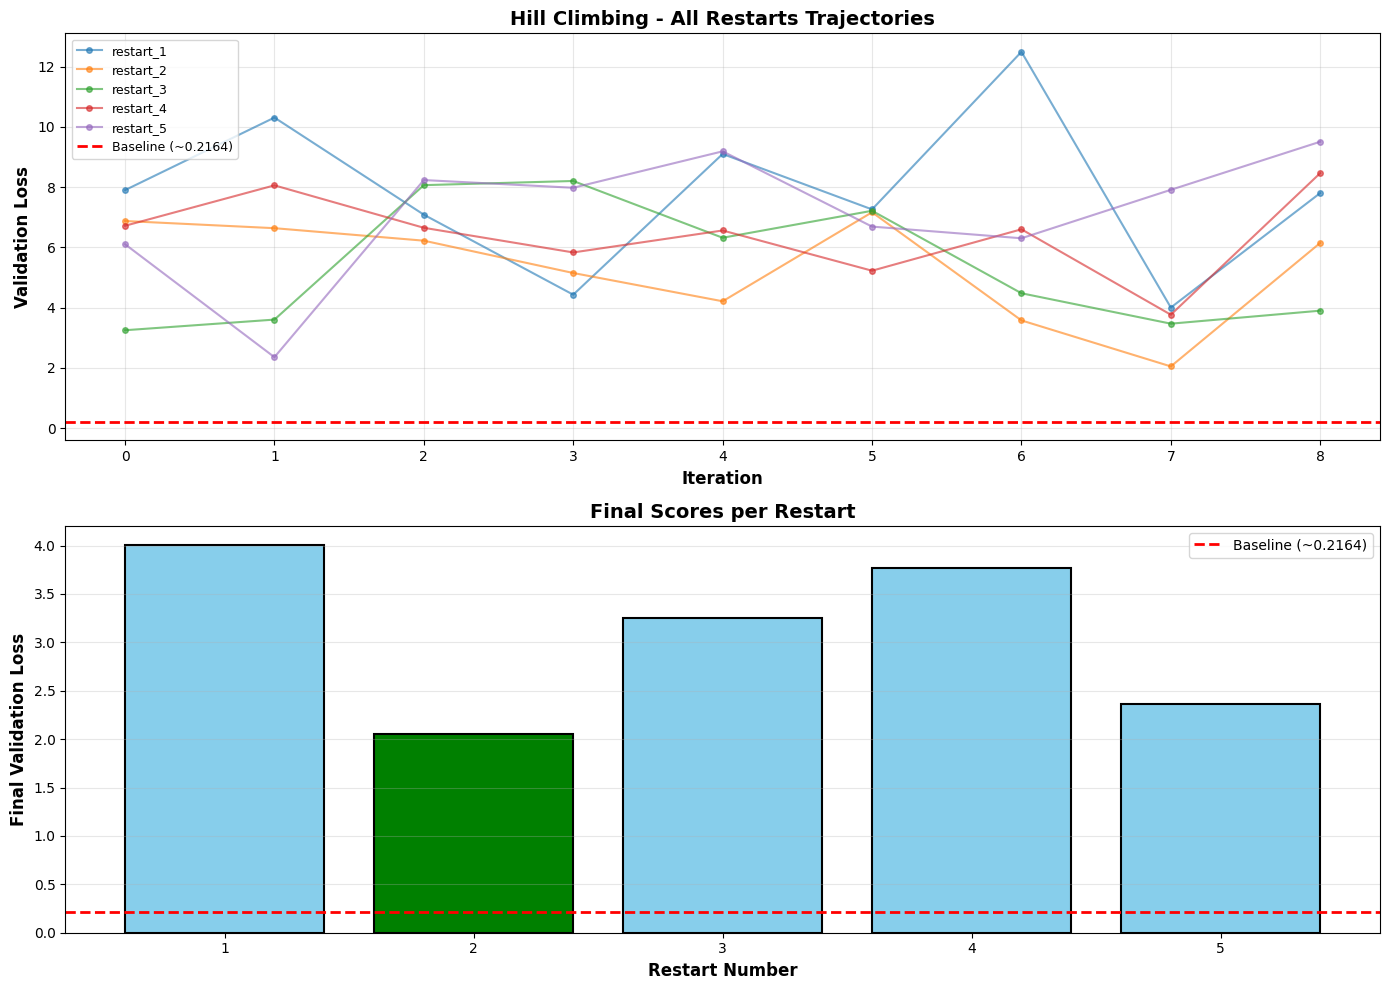

In [17]:
# Plot convergence
plot_hc_convergence(history_all, baseline_score=baseline_score,
                   save_path=os.path.join(SAVE_DIR, 'hc_convergence.png'))

**TRAIN FINAL MODEL**

Model: "BrainTumorCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 109)    │        94,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 109)    │           436 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 109)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 109)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 120)    │       117,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 85)             │     2,611,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 85)             │           340 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 42)             │         3,612 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           172 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831,690 (10.80 MB)

 Trainable params: 2,830,786 (10.80 MB)

 Non-trainable params: 904 (3.53 KB)


Training final model with longer epochs for evaluation...
Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.5361 - loss: 6.2809 - val_accuracy: 0.3427 - val_loss: 3.5997 - learning_rate: 0.0051
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.6553 - loss: 2.2555 - val_accuracy: 0.3848 - val_loss: 2.6345 - learning_rate: 0.0051
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.6572 - loss: 1.9431 - val_accuracy: 0.6971 - val_loss: 1.8573 - learning_rate: 0.0051
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6541 - loss: 1.8916 - val_accuracy: 0.3766 - val_loss: 2.6122 - learning_rate: 0.0051

 Final validation accuracy: 69.71% at epoch 3
 Improvement over baseline: -11.04%


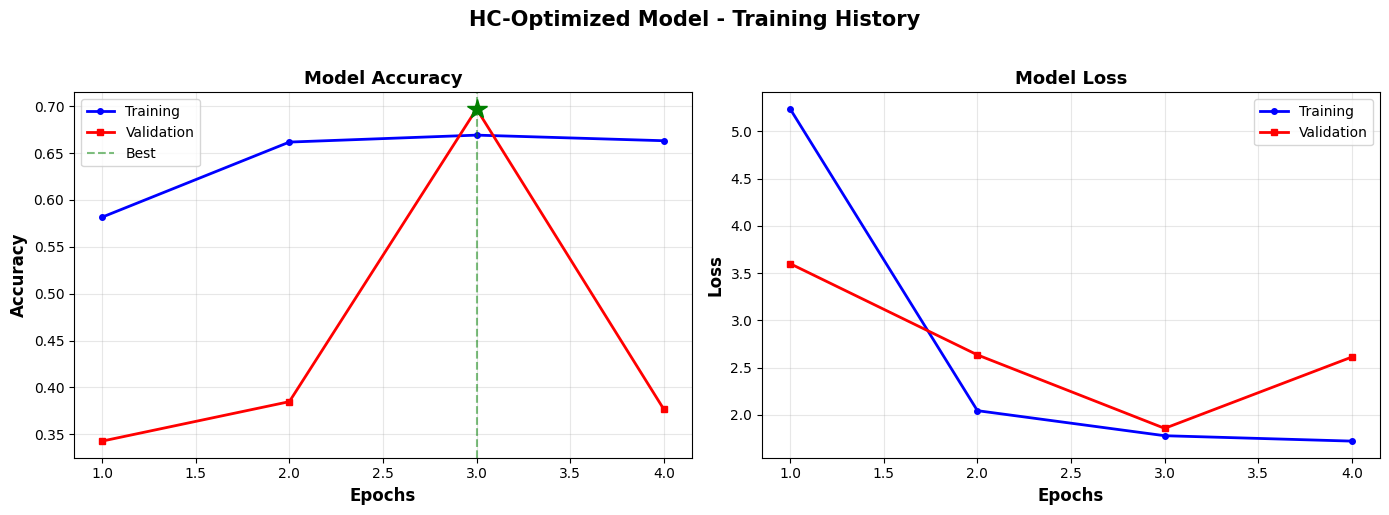


 Best Validation Accuracy: 69.71% at epoch 3


In [21]:
final_model = create_cnn_model(
    filters=[best_params['filter1'], best_params['filter2'], best_params['filter3']],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=best_params['l2_reg'],
    dense_units=best_params['dense_units'],
    input_shape=IMAGE_SHAPE,
    num_classes=len(class_names)
)

final_model.summary()

print("\nTraining final model with longer epochs for evaluation...")
final_hist, final_best_val_acc, final_time, final_epoch = train_and_evaluate(
    final_model,
    train,
    val,
    learning_rate=best_params['learning_rate'],
    optimizer_type='adam',
    epochs=50,
    patience=10,
    verbose=1
)

print(f"\n Final validation accuracy: {final_best_val_acc*100:.2f}% at epoch {final_epoch}")
if baseline_score:
    improvement = (final_best_val_acc - baseline_score) / baseline_score * 100
    print(f" Improvement over baseline: {improvement:+.2f}%")

plot_training_history(final_hist, "HC-Optimized Model - Training History")

**EVALUATE ON TEST SET**

EVALUATING HC-OPTIMIZED MODEL

 Test Accuracy: 56.52%
 Test Loss: 2.1083
CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.7202    0.4633    0.5639       300
  meningioma     0.3701    0.3399    0.3543       306
     notumor     0.6415    0.7333    0.6843       405
   pituitary     0.5374    0.6700    0.5964       300

    accuracy                         0.5652      1311
   macro avg     0.5673    0.5516    0.5498      1311
weighted avg     0.5723    0.5652    0.5596      1311

PER-CLASS ACCURACY
  glioma         : 46.33% (139/300)
  meningioma     : 33.99% (104/306)
  notumor        : 73.33% (297/405)
  pituitary      : 67.00% (201/300)


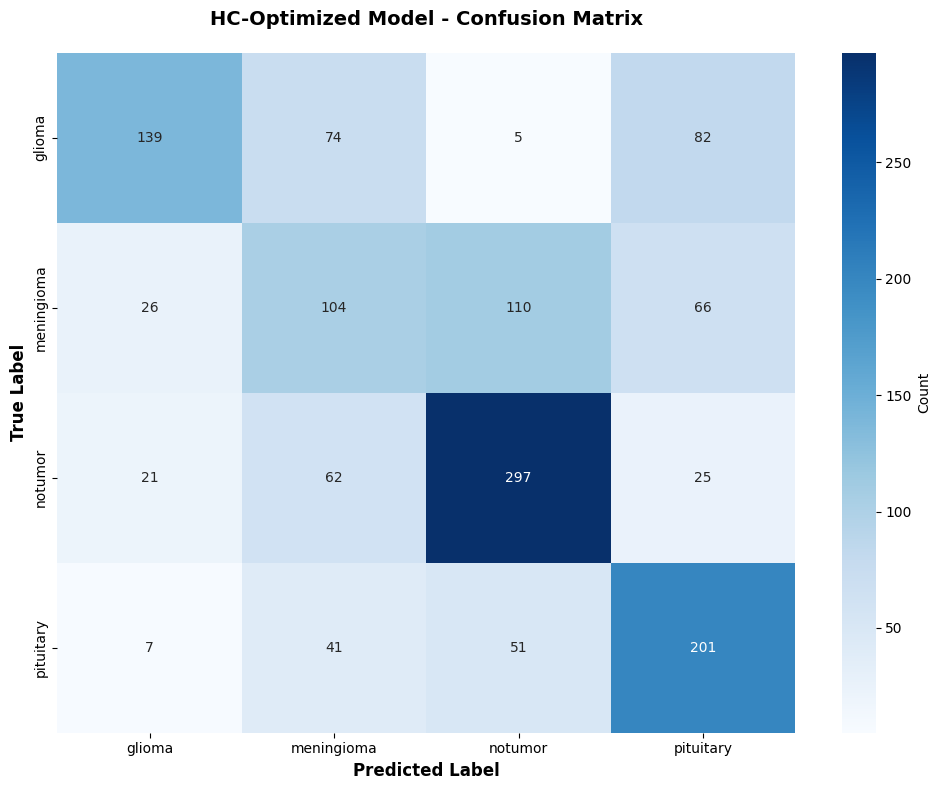

In [22]:
hc_results = evaluate_model(final_model, test, class_names, "HC-Optimized Model")
plot_confusion_matrix(hc_results['confusion_matrix'], 
                     class_names, "HC-Optimized Model - Confusion Matrix")

**SAVE MODELS AND RESULTS**

In [24]:
final_model.save(os.path.join(SAVE_DIR, "hc_optimized_model.keras"))
print(f" HC-optimized model saved as: {SAVE_DIR}/hc_optimized_model.keras")

# Save best parameters (already saved during optimization, but ensure final version)
params_to_save = {}
for key, value in best_params.items():
    if isinstance(value, (np.integer, np.floating)):
        params_to_save[key] = float(value)
    else:
        params_to_save[key] = value

with open(os.path.join(SAVE_DIR, "hc_best_params.json"), "w") as f:
    json.dump(params_to_save, f, indent=2)
print(f" Best parameters saved as: {SAVE_DIR}/hc_best_params.json")

# Save optimization history (already done, but confirm)
print(f" Optimization history saved as: {SAVE_DIR}/hc_history_final.pkl")

# Save training history
hc_history_dict = {
    'optimization': {
        'n_restarts': N_RESTARTS,
        'n_iterations': N_ITERS,
        'best_val_loss': float(best_score)
    },
    'training': {
        'accuracy': [float(x) for x in final_hist.history['accuracy']],
        'val_accuracy': [float(x) for x in final_hist.history['val_accuracy']],
        'loss': [float(x) for x in final_hist.history['loss']],
        'val_loss': [float(x) for x in final_hist.history['val_loss']]
    }
}

with open(os.path.join(SAVE_DIR, "hc_training_history.json"), "w") as f:
    json.dump(hc_history_dict, f, indent=2)
print(f" Training history saved as: {SAVE_DIR}/hc_training_history.json")

# Save results summary
hc_results_summary = {
    'optimization': {
        'algorithm': 'Hill Climbing with Random Restarts',
        'n_restarts': N_RESTARTS,
        'n_iterations_per_restart': N_ITERS,
        'total_evaluations': N_RESTARTS * (N_ITERS + 1),
        'epochs_per_eval': EPOCHS_PER_EVAL,
        'patience': PATIENCE,
        'best_val_loss_during_search': float(best_score),
        'best_parameters': params_to_save
    },
    'final_model': {
        'test_accuracy': float(hc_results['accuracy']),
        'test_loss': float(hc_results['loss']),
        'val_accuracy': float(final_best_val_acc),
        'best_epoch': int(final_epoch),
        'training_time_seconds': float(final_time)
    },
    'class_names': class_names
}

if baseline_available and baseline_score:
    hc_results_summary['baseline_comparison'] = {
        'baseline_test_accuracy': float(baseline_test_results['accuracy']),
        'baseline_val_accuracy': float(baseline_score),
        'test_accuracy_improvement': float(hc_results['accuracy'] - baseline_test_results['accuracy']),
        'test_accuracy_improvement_percent': float((hc_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100),
        'val_accuracy_improvement': float(final_best_val_acc - baseline_score),
        'val_accuracy_improvement_percent': float((final_best_val_acc - baseline_score) / baseline_score * 100)
    }

with open(os.path.join(SAVE_DIR, "hc_results_summary.json"), "w") as f:
    json.dump(hc_results_summary, f, indent=2)
print(f" Results summary saved as: {SAVE_DIR}/hc_results_summary.json")

if baseline_available and baseline_score:
    comparison.to_csv(os.path.join(SAVE_DIR, "model_comparison.csv"), index=False)
    print(f" Model comparison saved as: {SAVE_DIR}/model_comparison.csv")

# Create a zip file for easy download
try:
    import zipfile
    zipname = os.path.join(SAVE_DIR, "hc_model_and_logs.zip")
    with zipfile.ZipFile(zipname, 'w') as z:
        z.write(os.path.join(SAVE_DIR, "hc_best_params.json"), "hc_best_params.json")
        z.write(os.path.join(SAVE_DIR, "hc_best_score.txt"), "hc_best_score.txt")
        z.write(os.path.join(SAVE_DIR, "hc_history_final.pkl"), "hc_history_final.pkl")
        z.write(os.path.join(SAVE_DIR, "hc_optimized_model.keras"), "hc_optimized_model.keras")
        z.write(os.path.join(SAVE_DIR, "hc_results_summary.json"), "hc_results_summary.json")
        if os.path.exists(os.path.join(SAVE_DIR, "model_comparison.csv")):
            z.write(os.path.join(SAVE_DIR, "model_comparison.csv"), "model_comparison.csv")
    print(f" Created zip archive: {zipname}")
except Exception as e:
    print(f" Could not create zip: {e}")

 HC-optimized model saved as: /kaggle/working/hc_outputs/hc_optimized_model.keras
 Best parameters saved as: /kaggle/working/hc_outputs/hc_best_params.json
 Optimization history saved as: /kaggle/working/hc_outputs/hc_history_final.pkl
 Training history saved as: /kaggle/working/hc_outputs/hc_training_history.json
 Results summary saved as: /kaggle/working/hc_outputs/hc_results_summary.json
 Model comparison saved as: /kaggle/working/hc_outputs/model_comparison.csv
 Created zip archive: /kaggle/working/hc_outputs/hc_model_and_logs.zip


**FINAL SUMMARY**

In [27]:
print(f"\nHC-Optimized Model Performance:")
print(f"  Validation Accuracy: {final_best_val_acc*100:.2f}%")
print(f"  Training Time:       {final_time/60:.2f} minutes")
print(f"  Best Epoch:          {final_epoch}")

print(f"\nBest Hyperparameters Found:")
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param:15s}: {value:.6f}")
    else:
        print(f"  {param:15s}: {value}")

print(f"\nHill Climbing Statistics:")
print(f"  Restarts:           {N_RESTARTS}")
print(f"  Iterations/restart: {N_ITERS}")
print(f"  Total evaluations:  {N_RESTARTS * (N_ITERS + 1)}")
print(f"  Epochs per eval:    {EPOCHS_PER_EVAL}")
print(f"  Total time:         {t_elapsed:.2f} minutes")
print(f"  Best val loss:      {best_score:.6f}")

print(f"\nSaved Files in {SAVE_DIR}:")
print(f"  - hc_optimized_model.keras")
print(f"  - hc_best_params.json")
print(f"  - hc_best_score.txt")
print(f"  - hc_history_final.pkl")
print(f"  - hc_training_history.json")
print(f"  - hc_results_summary.json")
print(f"  - hc_convergence.png")
print(f"  - hc_model_and_logs.zip")
if baseline_available and baseline_score:
    print(f"  - model_comparison.csv")
    print(f"  - confusion_matrix_comparison.png")
    print(f"  - per_class_comparison.png")
print(f"  - Checkpoint files (hc_history_checkpoint_restart*.pkl)")
print(f"Hill Climbing workflow complete. Check the directory: {SAVE_DIR}")


HC-Optimized Model Performance:
  Validation Accuracy: 69.71%
  Training Time:       25.36 minutes
  Best Epoch:          3

Best Hyperparameters Found:
  learning_rate  : 0.005145
  dropout_rate   : 0.200000
  l2_reg         : 0.003575
  filter1        : 96
  filter2        : 109
  filter3        : 120
  dense_units    : 85

Hill Climbing Statistics:
  Restarts:           5
  Iterations/restart: 8
  Total evaluations:  45
  Epochs per eval:    10
  Total time:         141.64 minutes
  Best val loss:      2.051344

Saved Files in /kaggle/working/hc_outputs:
  - hc_optimized_model.keras
  - hc_best_params.json
  - hc_best_score.txt
  - hc_history_final.pkl
  - hc_training_history.json
  - hc_results_summary.json
  - hc_convergence.png
  - hc_model_and_logs.zip
  - model_comparison.csv
  - confusion_matrix_comparison.png
  - per_class_comparison.png
  - Checkpoint files (hc_history_checkpoint_restart*.pkl)
Hill Climbing workflow complete. Check the directory: /kaggle/working/hc_outputs
